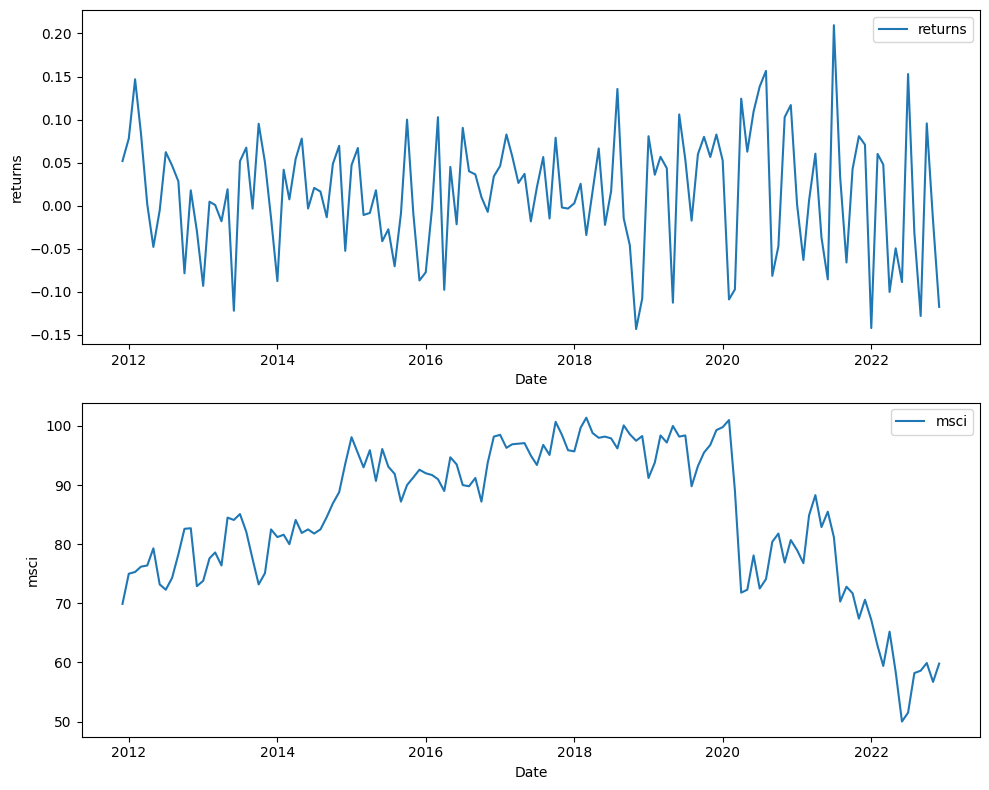

In [61]:
#This script performs a short preliminary analysis of the time series data at hand
# First section: visual inspection of all variables
# Second section: tests for stationarity, autocorrelation, and unit roots


import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import os as os

df = pd.read_csv('./tsdata/preprocessed_data.csv', index_col='Date', parse_dates=True)

#Plotting time series
num_variables = len(df.columns)
fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(10, num_variables * 4))
if num_variables == 1:
    axes = [axes]
for ax, column in zip(axes, df.columns):
    ax.plot(df.index, df[column], label=f'{column}')
    ax.set_xlabel('Date')
    ax.set_ylabel(column)
    ax.legend()

plt.tight_layout()
plt.show()

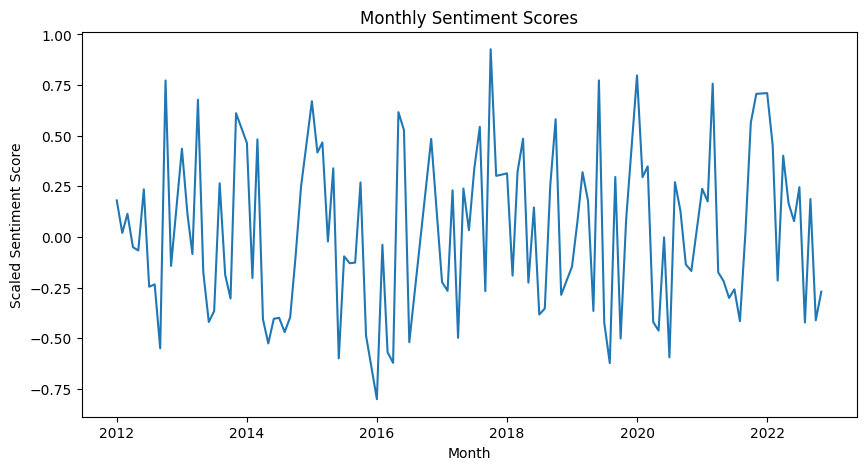

In [62]:
sentiment = pd.read_csv("./Sentiment_data/sentiment_scores.csv")
sentiment['month'] = pd.to_datetime(sentiment['month'], format='%Y%m')

plt.figure(figsize=(10, 5))
plt.plot(sentiment['month'], sentiment['scaled_scores'])

plt.title('Monthly Sentiment Scores')
plt.xlabel('Month')
plt.ylabel('Scaled Sentiment Score')
plt.show() 

In [63]:
#From inspecting the graphs, we can clearly see non-stationary features from all variables under consideration, suggesting to difference/fitting and ARIMA model
# We can further test the hypothesis of stationarity by testing for unit roots using the Augemented Dickey fuller test. To test for autocorrelation, we use the Ljung-Box test.

def perform_adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic for {series.name}: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
    if result[1] < 0.05:
        print("Evidence against null hypothesis, data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root indicating it is non-stationary")

for column in df.columns:
    perform_adf_test(df[column])

print(f'ADF Statistic for sentiment score: {adfuller(sentiment["scaled_scores"])[0]}')


ADF Statistic for returns: -9.878610437516175
p-value: 3.8229032853452e-17
Critical Value (1%): -3.481281802271349
Critical Value (5%): -2.883867891664528
Critical Value (10%): -2.5786771965503177
Evidence against null hypothesis, data has no unit root and is stationary
ADF Statistic for msci: -0.13087896968919818
p-value: 0.9462746836236046
Critical Value (1%): -3.482920063655088
Critical Value (5%): -2.884580323367261
Critical Value (10%): -2.5790575441750883
Weak evidence against null hypothesis, time series has a unit root indicating it is non-stationary
ADF Statistic for sentiment score: -5.910218592430025


In [64]:
df["msci"] = df["msci"].diff().dropna()
df = df.iloc[1:]

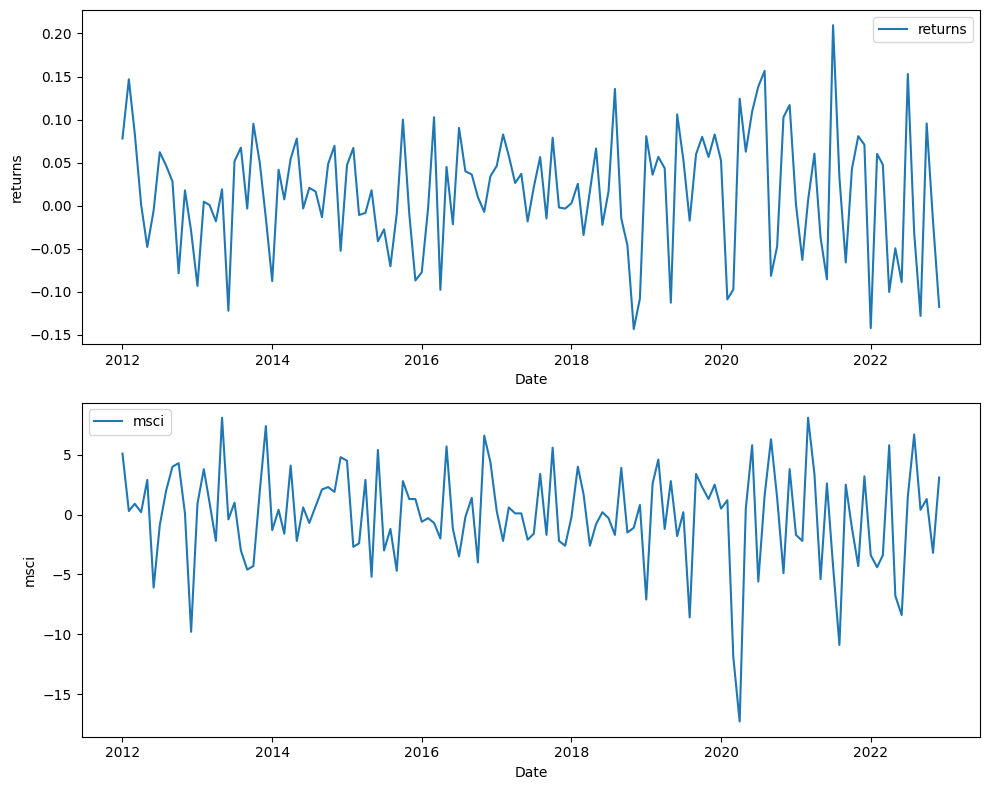

In [65]:
num_variables = len(df.columns)
fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(10, num_variables * 4))
if num_variables == 1:
    axes = [axes]
for ax, column in zip(axes, df.columns):
    ax.plot(df.index, df[column], label=f'{column}')
    ax.set_xlabel('Date')
    ax.set_ylabel(column)
    ax.legend()

plt.tight_layout()
plt.show()

In [66]:
for column in df.columns:
    perform_adf_test(df[column])

df.to_csv("./tsdata/modeldata.csv")

ADF Statistic for returns: -10.14625023943689
p-value: 8.171422372872756e-18
Critical Value (1%): -3.4816817173418295
Critical Value (5%): -2.8840418343195267
Critical Value (10%): -2.578770059171598
Evidence against null hypothesis, data has no unit root and is stationary
ADF Statistic for msci: -7.137877542698444
p-value: 3.383743633380216e-10
Critical Value (1%): -3.482920063655088
Critical Value (5%): -2.884580323367261
Critical Value (10%): -2.5790575441750883
Evidence against null hypothesis, data has no unit root and is stationary
